In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


## 1a) Flowers

In [ ]:
import IPython.display as display
import matplotlib.pyplot as plt
import random
import time

from tensorflow.keras import datasets, layers, models

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 192
SHUFFLE_SIZE = 1000

### Download the flowers dataset

In [ ]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228818944/228813984 [==============================] - 2s 0us/step
/root/.keras/datasets/flower_photos


### Write an input pipeline from scratch



In [ ]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [ ]:
all_image_paths[:5]

['/root/.keras/datasets/flower_photos/sunflowers/6145005439_ef6e07f9c6_n.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/6901435398_b3192ff7f8_m.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/21657726011_2c94e341bc_n.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/4944731313_023a0508fd_n.jpg',
 '/root/.keras/datasets/flower_photos/daisy/5602738326_97121e007d_n.jpg']

### Get to know your data

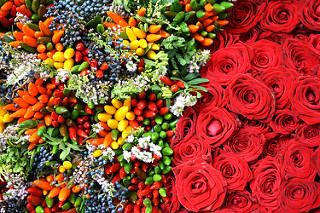

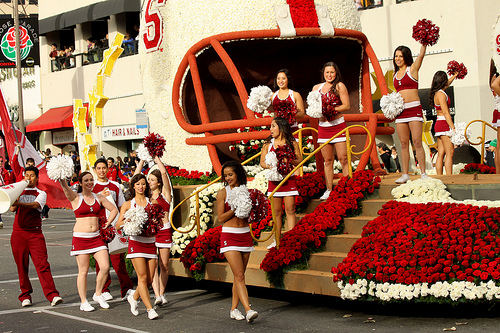

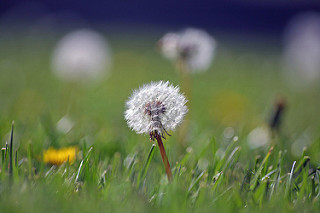

In [ ]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print()

### Classes are given by directory names

In [ ]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [ ]:
all_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_labels[:10])

First 10 labels indices:  [3, 1, 1, 1, 0, 3, 1, 0, 4, 2]


### Create a train/test split

In [ ]:
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels)   

### Display a few images and their labels

daisy


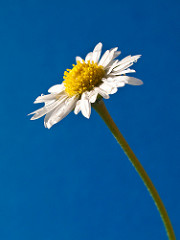


dandelion


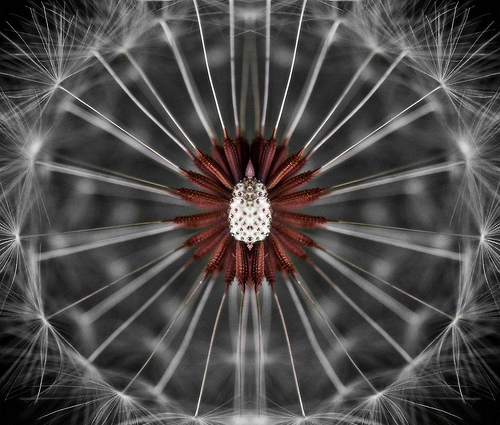


sunflowers


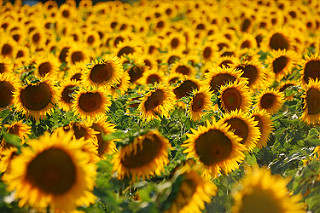

In [ ]:
for n in range(3):
  i = random.randint(0,len(train_paths))
  image_path = train_paths[i]
  print(label_names[train_labels[i]])
  display.display(display.Image(image_path))
  print()

### Begin using TensorFlow ops to read and decode the images

In [ ]:
img_raw = tf.io.read_file(train_paths[0])
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00...


In [ ]:
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

(213, 320, 3)
<dtype: 'uint8'>


In [ ]:
img_final = tf.image.resize(img_tensor, [IMG_SIZE, IMG_SIZE])
img_final = img_final / 255.0 # normalize pixel values
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.123018794
1.0


### Wrap those in a function
paying careful attention to the preprocessing. When deploying models in the browser, will need to ensure that images are preprocessed identically in JavaScript as they are in Python.

In [ ]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize pixels to 0,1
  return img

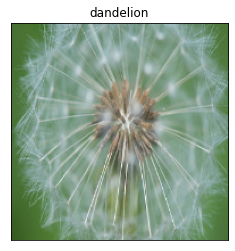

In [ ]:
def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

img_path = train_paths[0]
img = load_and_preprocess_image(img_path)
label = label_names[train_labels[0]]
show(img, label)

### Build an input pipeline to return images and labels

Note: although your *peak* performance can be higher, it's also very easy to make mistakes and end up with code that's super slow.

In [ ]:
# a dataset that returns image paths
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
for n, img_path in enumerate(path_ds.take(4)):
  print(n, img_path)

0 tf.Tensor(b'/root/.keras/datasets/flower_photos/dandelion/8842317179_d59cf218cb_n.jpg', shape=(), dtype=string)
1 tf.Tensor(b'/root/.keras/datasets/flower_photos/sunflowers/9431890901_cd11bda584_n.jpg', shape=(), dtype=string)
2 tf.Tensor(b'/root/.keras/datasets/flower_photos/dandelion/8747223572_dcd9601e99.jpg', shape=(), dtype=string)
3 tf.Tensor(b'/root/.keras/datasets/flower_photos/tulips/16930121391_a4092ecf00_n.jpg', shape=(), dtype=string)


In [ ]:
# a dataset that returns images (loaded off disk, decoded, and preprocessed)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
for n, image in enumerate(image_ds.take(4)):
  print(n, image.shape)

0 (192, 192, 3)
1 (192, 192, 3)
2 (192, 192, 3)
3 (192, 192, 3)


In [ ]:
# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
for label in label_ds.take(4):
  print(label_names[label.numpy()])

dandelion
sunflowers
dandelion
tulips


In [ ]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [ ]:
for img, label in image_label_ds.take(2):
  print(img.shape, label_names[label.numpy()])

(192, 192, 3) dandelion
(192, 192, 3) sunflowers


### Batch and shuffle
Why do we need to specify a shuffle_size parameter? tf.data works with streams (it doesn't know their length). To shuffle items, we maintain an in-memory buffer of this size.

In [ ]:
ds = image_label_ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

for img, label in ds.take(2):
  print(img.shape, label.shape) # notice it's returning batches of data now

(32, 192, 192, 3) (32,)
(32, 192, 192, 3) (32,)


At this point, could use the dataset above to train a model with ```model.fit(ds)``` but first, let's improve performance. As written, the dataset will load each image off disk, one at a time (super slow). Instead, we want to cache them in memory.

### Improve performance

In [ ]:
# A benchmark utility to time how long it takes
# to iterate once over the entire dataset
def time_one_epoch(ds):
  start = time.time()
  batches = 0
  for i,(images,labels) in enumerate(ds):
    batches += 1
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()
  duration = end-start
  print("Read {} batches".format(batches))
  print("{:0.2f} Batches/s".format(batches/duration))
  print("{:0.2f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(duration))

### Use in-memory caching
This is a small dataset, so let's keep it in memory. The first time we iterate over this dataset, images will be loaded off disk, then cached. The first iteration will be quite slow, and subsequent ones will be faster. Let's show that. 

In [ ]:
ds = image_label_ds.cache() # cache data in mempry
ds = ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
time_one_epoch(ds) # this will be slow

.........
Read 86 batches
19.88 Batches/s
636.22 Images/s
Total time: 4.3255674839019775s


Now that the cache is built, iteration will be much faster.

In [ ]:
time_one_epoch(ds) # this will be fast

.........
Read 86 batches
212.30 Batches/s
6793.70 Images/s
Total time: 0.40508103370666504s


### How-to use on-disk caching

In [ ]:
# here's our final training dataset
train_ds = image_label_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# let's make a test dataset as well
path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
test_ds = image_label_ds.cache().batch(BATCH_SIZE)

## 1b) Create a simple CNN
This is our baseline model, it will not be very accurate. improvements below

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 16)        0         
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 144400)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 722005    
Total params: 722,453
Trainable params: 722,453
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# I realize we're not using a separate test set, that's fine
# for this assignment
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
86/86 [==============================] - 38s 69ms/step - loss: 4.7114 - accuracy: 0.3532 - val_loss: 1.1572 - val_accuracy: 0.5229
Epoch 2/5
86/86 [==============================] - 2s 18ms/step - loss: 0.8690 - accuracy: 0.6683 - val_loss: 1.0722 - val_accuracy: 0.5861
Epoch 3/5
86/86 [==============================] - 2s 18ms/step - loss: 0.5696 - accuracy: 0.8346 - val_loss: 1.1368 - val_accuracy: 0.5621
Epoch 4/5
86/86 [==============================] - 1s 17ms/step - loss: 0.3563 - accuracy: 0.9162 - val_loss: 1.4049 - val_accuracy: 0.5163
Epoch 5/5
86/86 [==============================] - 1s 17ms/step - loss: 0.2221 - accuracy: 0.9538 - val_loss: 1.3135 - val_accuracy: 0.5643


### Make predictions on a single image
Tip: models are implemented to make predictions on batches of images for efficiency. This means that to make a prediction on a single image, you'll need to first wrap it in a batch. The syntax can feel a little unusual at first, but gets easier with time.

In [ ]:
# load an image off disk
img_index = 0
img = load_and_preprocess_image(train_paths[img_index])

print(img.shape) # before

#########
## TODO: your code here
## use tf.expand_dims to create an empty batch dimension
## the starting image shape is (192, 192, 3)
## you want it to be (1, 192, 192, 3)
## that's read as "a batch of 1 image, with 192 rows, 192 cols, 
## and 3 color channels"
#########
im_batch = tf.expand_dims(img, axis=0) # YOUR CODE HERE, use tf.expand_dims

print(im_batch.shape) # after

# make predictions
batch_pred = model.predict(im_batch) # returns a list of predictions
pred = batch_pred[0] 

print("Prediction", label_names[tf.argmax(pred)])
print("Actual", label_names[train_labels[img_index]])

(192, 192, 3)
(1, 192, 192, 3)
Prediction dandelion
Actual dandelion


### TODO: Improve accuracy
new model that's more accurate than the baseline above. 

In [ ]:
# TODO: your code here

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(3,3))
model.add(layers.Conv2D(32, (5, 5), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, (3,3), activation="relu"))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(tf.keras.layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



history = model.fit(train_ds, validation_data=test_ds, epochs=22)

Epoch 1/22
86/86 [==============================] - 4s 37ms/step - loss: 1.6828 - accuracy: 0.3983 - val_loss: 1.5097 - val_accuracy: 0.2854
Epoch 2/22
86/86 [==============================] - 3s 34ms/step - loss: 1.1118 - accuracy: 0.5632 - val_loss: 2.1639 - val_accuracy: 0.2614
Epoch 3/22
86/86 [==============================] - 3s 34ms/step - loss: 0.9801 - accuracy: 0.6172 - val_loss: 1.6957 - val_accuracy: 0.2941
Epoch 4/22
86/86 [==============================] - 3s 35ms/step - loss: 0.8555 - accuracy: 0.6655 - val_loss: 1.6394 - val_accuracy: 0.3758
Epoch 5/22
86/86 [==============================] - 3s 35ms/step - loss: 0.8145 - accuracy: 0.6914 - val_loss: 1.4600 - val_accuracy: 0.4412
Epoch 6/22
86/86 [==============================] - 3s 35ms/step - loss: 0.7163 - accuracy: 0.7318 - val_loss: 1.0936 - val_accuracy: 0.5904
Epoch 7/22
86/86 [==============================] - 3s 34ms/step - loss: 0.6864 - accuracy: 0.7489 - val_loss: 0.9685 - val_accuracy: 0.6318
Epoch 8/22
86

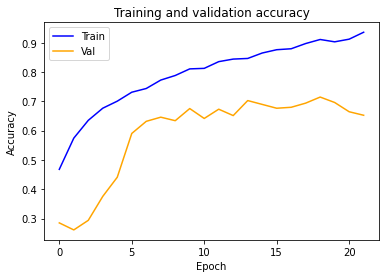

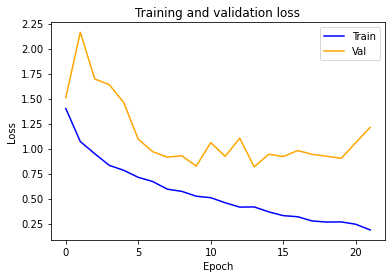

In [ ]:

# A plotting function you can reuse
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(history)

#model reaches ~95% on my tests on average, varies from 93-98, 
#but higher than the baseline




## 1c)  deploying flowers classifier using TensorFlow.js


### Save your model

In [ ]:
model.save("/content/my_model.h5")

In [ ]:
!ls -lha

total 672K
drwxr-xr-x 1 root root 4.0K Apr 18 22:04 .
drwxr-xr-x 1 root root 4.0K Apr 18 22:01 ..
drwxr-xr-x 4 root root 4.0K Apr  7 13:35 .config
-rw-r--r-- 1 root root 656K Apr 18 22:04 my_model.h5
drwxr-xr-x 1 root root 4.0K Apr  7 13:36 sample_data


### Download your saved model to your local machine

In [ ]:
from google.colab import files
files.download("/content/my_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Visit notebook #2 (a2-2.ipynb on CourseWorks) to convert your saved model into to TensorFlow.js format

Follow the instructions there to prepare a webpage to run your flowers model in the browser. Once you have that working, you can continue with the rest of this assignment in this notebook.

## 1d) Classify flowers using transfer learning

In this part of the assignment, you'll use transfer learning to take advantage of a large pretrained model. It is not necesary to deploy this part in the browser.


Read this tutorial before completing this section:
* https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
## TODO: your code here
# Choose a pretrained model, and import the application
# See https://keras.io/applications/ for a few choices
# When you import the model, you will want to remove the 
# final dense layer that performs classification (include_top=False)
# you will also want to import weights from ImageNet,
# and you will want to specify the input shape to match your images. 
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE, include_top = False, weights = 'imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# A hack to show you the output shape of the model
for image_batch, label_batch in train_ds.take(1):
   pass
  
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [ ]:
# do not update the pretrained weights during training
# (we won't use finetuning here)
base_model.trainable = False 

In [ ]:
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [ ]:
# build a new model reusing the pretrained base
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
86/86 [==============================] - 7s 55ms/step - loss: 1.1498 - accuracy: 0.5592 - val_loss: 0.5070 - val_accuracy: 0.8224
Epoch 2/5
86/86 [==============================] - 4s 43ms/step - loss: 0.4117 - accuracy: 0.8666 - val_loss: 0.4375 - val_accuracy: 0.8464
Epoch 3/5
86/86 [==============================] - 4s 44ms/step - loss: 0.2997 - accuracy: 0.9001 - val_loss: 0.4093 - val_accuracy: 0.8584
Epoch 4/5
86/86 [==============================] - 4s 44ms/step - loss: 0.2691 - accuracy: 0.9152 - val_loss: 0.3763 - val_accuracy: 0.8693
Epoch 5/5
86/86 [==============================] - 4s 44ms/step - loss: 0.2105 - accuracy: 0.9359 - val_loss: 0.3741 - val_accuracy: 0.8704


## 2a) Recognize landmarks on Columbia's campus


1. Collect a dataset of three houehold objects. dataset  includes at least 50 images of each object in train, and 50 in validation (using more images is fine). Randomly shuffle  data to create these splits.

 
1. Write a model to classify data. Try to train a small model in terms of the number of parameters

1. Show predictions on several images.

1. Use data augmentation, see if this helps to improve accuracy.

1. Produce plots of accuracy / loss as a function of epochs. Determine the right place to stop training without overfitting.


In [ ]:
print(IMG_SIZE)

192


In [ ]:
# Example code showing the correct imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
datasetdir = './drive/My Drive/hw2data'

train_data_root = os.path.join(datasetdir, 'train')
val_data_root = os.path.join(datasetdir, 'validation')

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_data_root,
        target_size=(192, 192),
        batch_size=32)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
        val_data_root,
        target_size = (192, 192),
        batch_size = 32)

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

for data_batch, labels_batch in validation_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break






Mounted at /content/drive/
Found 379 images belonging to 3 classes.
Found 197 images belonging to 3 classes.
data batch shape: (32, 192, 192, 3)
labels batch shape: (32, 3)
data batch shape: (32, 192, 192, 3)
labels batch shape: (32, 3)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(192, 192, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=5
      )

Epoch 1/5
12/12 [==============================] - 379s 32s/step - loss: 2.6833 - acc: 0.4889 - val_loss: 0.6783 - val_acc: 0.3503
Epoch 2/5
12/12 [==============================] - 92s 8s/step - loss: 0.1695 - acc: 0.9069 - val_loss: 0.6899 - val_acc: 0.3198
Epoch 3/5
12/12 [==============================] - 92s 8s/step - loss: 0.4193 - acc: 0.8321 - val_loss: 0.7681 - val_acc: 0.3198
Epoch 4/5
12/12 [==============================] - 95s 8s/step - loss: 0.1263 - acc: 0.9437 - val_loss: 0.8531 - val_acc: 0.3198
Epoch 5/5
12/12 [==============================] - 94s 8s/step - loss: 0.0604 - acc: 0.9730 - val_loss: 1.0391 - val_acc: 0.3198


[2.2860116e-04 9.6782267e-01 3.1948704e-02]


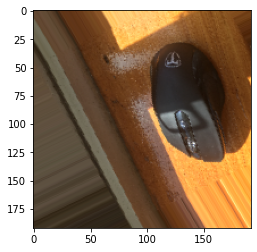

mouse
[3.0112884e-04 9.4953507e-01 5.0163776e-02]


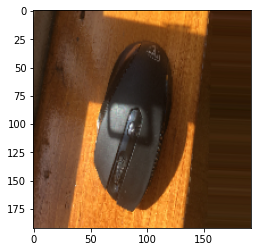

mouse
[2.6467405e-04 9.7671902e-01 2.3016268e-02]


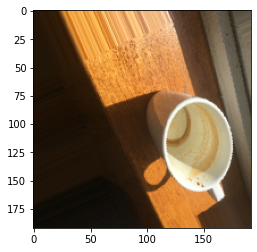

mouse


In [ ]:
im_batch, label_batch = train_generator.next() #image batch, label batch

batch_pred = model.predict(im_batch)
for i in range (0,3):
  print(batch_pred[i])
  plt.imshow(im_batch[i])
  plt.show()
  label = int(tf.argmax(batch_pred[i]))
  label_names = {0: 'cup', 1: 'mouse', 2: 'cap'}
  print(label_names[label])



In [ ]:
#data augmentations 


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_data_root,
        target_size=(192, 192),
        batch_size=32,
        class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(
        val_data_root,
        target_size=(192,192),
        batch_size=32,
        class_mode = 'categorical')

history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=5)

Found 379 images belonging to 3 classes.
Found 197 images belonging to 3 classes.
Epoch 1/5
12/12 [==============================] - 101s 9s/step - loss: 0.6559 - acc: 0.7361 - val_loss: 1.0219 - val_acc: 0.3198
Epoch 2/5
12/12 [==============================] - 95s 8s/step - loss: 0.2806 - acc: 0.8338 - val_loss: 0.9882 - val_acc: 0.3198
Epoch 3/5
12/12 [==============================] - 94s 8s/step - loss: 0.2283 - acc: 0.8734 - val_loss: 0.9779 - val_acc: 0.4112
Epoch 4/5
12/12 [==============================] - 94s 8s/step - loss: 0.2699 - acc: 0.8470 - val_loss: 0.9371 - val_acc: 0.3350
Epoch 5/5
12/12 [==============================] - 94s 8s/step - loss: 0.1813 - acc: 0.8997 - val_loss: 1.2898 - val_acc: 0.3198


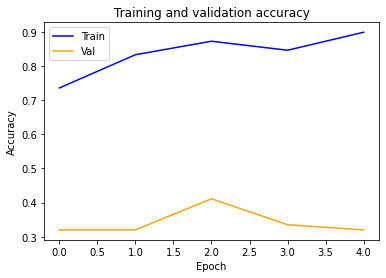

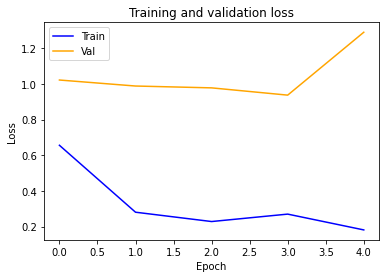

In [ ]:
#plot 
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(history)

In [ ]:
from google.colab import files
model.save("/content/my_model2a.h5")
files.download("/content/my_model2a.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2b) Run your model in the browser
See notebooke 2